Francis Bautista 2018-21128 PS3

In [8]:
import numpy as np
import os
import cv2 as cv
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use('fivethirtyeight')

### Data Processing
In the first few steps, loading, tagging, and and formatting of the data is done. The **gender_list** variable is a manually tagged list of visually identifiable genders. Any politically correctness issues with how these are identified is ignored for experimentation's sake.

In [3]:
gender_list = list("mmmmmmmfmfmmmmmmmmmmmmmmmmmmmmmfmmfmmmmm")

Loop through directory, access each first image, flatten the 2D matrix onto a vector, and append to the **A** list, effectively creating a 2D matrix where each row is an image.

In [13]:
rootdir = "data/att_faces/"
X = []
for i in list(range(1,41)):
    img = cv2.imread(f"data/att_faces/s{i}/1.pgm",0)
    X.append(img.flatten())

Check for dimensionality correctness for the entire dataset and for each image.

In [4]:
X = np.array(X)
print(X.shape)
print(X[0].shape)

(40, 10304)
(10304,)


Compute for the mean face to normalize dataset

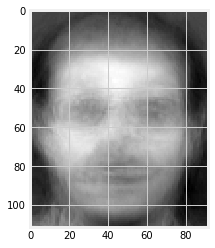

In [5]:
mean_face = np.mean(X, 0)
mf = mean_face.reshape(112,92)
plt.imshow(mf, cmap='gray')

Elementwise subtraction by the mean face vector is done to center and normalize the dataset. Shown below is a comparison of the non-normalized image on the left, and the normalized image on the right.

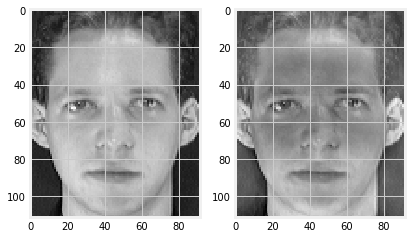

In [6]:
# Adjusted and centered A
A = X - mean_face
f1 = X[0].reshape(112,92)
f2 = A[0].reshape(112,92)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(f1, cmap='gray')
axarr[1].imshow(f2, cmap='gray')

### Compute for the SVD and Principal Components of the Faces
The following steps compute for the **Singular Value Decomposition** of the matrix **A** and its 2 principal components. Numpy is used for the core computations in this section.

In [7]:
U, S, V = np.linalg.svd(A, full_matrices=False)

Validate dimensionality for the U, Sigma, V-transpose computation from SVD

In [8]:
print("A:", A.shape)
print("U:", U.shape)
print("Sigma:", S.shape)
print("V^T:", V.shape)

A: (40, 10304)
U: (40, 40)
Sigma: (40,)
V^T: (40, 10304)


Display the **first 4** *eigenfaces* from the SVD resultant matrix.

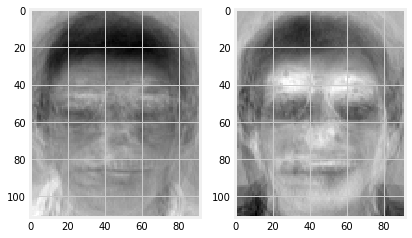

In [9]:
e1 = V[0].reshape(112,92)
e2 = V[1].reshape(112,92)
e3 = V[2].reshape(112,92)
e4 = V[3].reshape(112,92)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(e1, cmap='gray')
axarr[1].imshow(e2, cmap='gray')

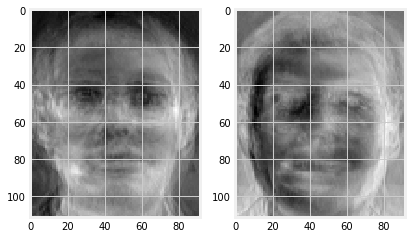

In [10]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(e3, cmap='gray')
axarr[1].imshow(e4, cmap='gray')

### Analysis of Results
A dataframe of projections is computed with plots of the dataset displayed below.

A dataframe was built with arbitrary X and Y coordinates from the projection, and a map to the genders identified in the initial step in this notebook.

In [11]:
projections = np.matmul(A, V[:2,:].T)
df = pd.DataFrame(
    {'x': [x[0] for x in projections],
     'y': [x[1] for x in projections],
     'gender': gender_list
    })

A scatterplot displaying each face colored by gender and tagged by index or directory source is displayed below. Directory source is included as a tag to present image similarities in the analysis. The gender distribution disparity presents a challenge in the distinguishing of male or female images using first 2 principal components. The female-tagged images seem to be within the ~1000s range for the y-axis, however, this is more likely due to a sampling issue than latent characteristics within the data.

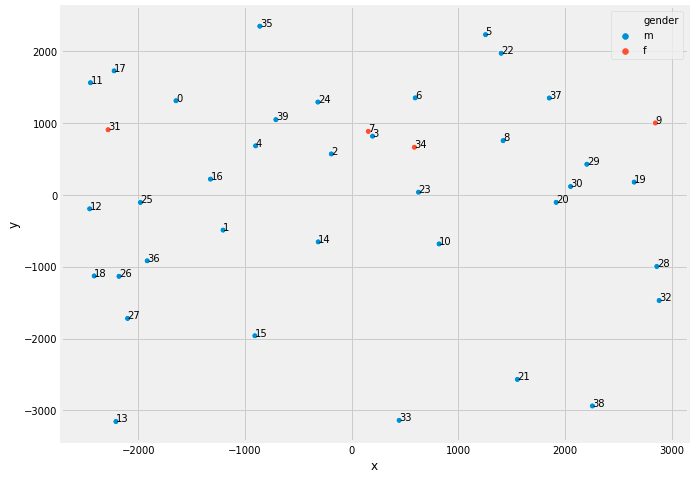

In [12]:
plt.figure(figsize=(10,8))
pl = sns.scatterplot(df.x, df.y, hue=df.gender)
df["index_col"] = df.index
for line in range(0,df.shape[0]):
     pl.text(df.x[line]+0.4, df.y[line], df.index_col[line], horizontalalignment='left', color='black')

KMeans is done with 2 centroids to identify organic groupings of the faces. The elbow method shows an **optimal k of 2**.

From a visual analysis of the algorthimically generated cluster centroids, the **key differentiator between the 2 clusters is hair-color**. This is corroborated by examining the n-nearest neighbors of each centroid and validating similarities between images. 

Image 20, 29, and 30, which are closest to the purple cluster centroid are images of persons with dark-colored hair in full-frame of the image.

Image 1, 15, and 25 are photographs of persons with light-colored hair or hair that has been cropped out of frame.

An analysis of the centroids of a clustering with k=2 done on the matrix A shows that the differentiator is hair-color. This however, is not the best analysis of image similarity, as kmeans is purely distance-based metric, and given the nature of the images in the dataset, only really emphasizes strong color differences and not facial or accessory features.

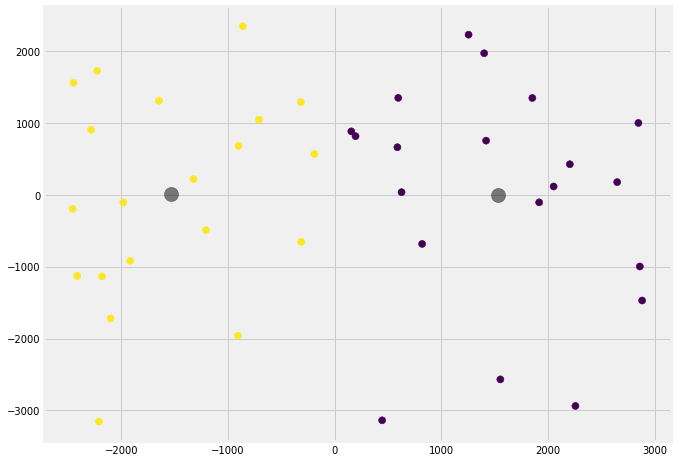

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(projections)
y_kmeans = kmeans.predict(projections)
plt.figure(figsize=(10,8))
plt.scatter(projections[:, 0], projections[:, 1], c=y_kmeans, s=50, cmap='viridis')


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [14]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(projections)
    sum_of_squared_distances.append(km.inertia_)

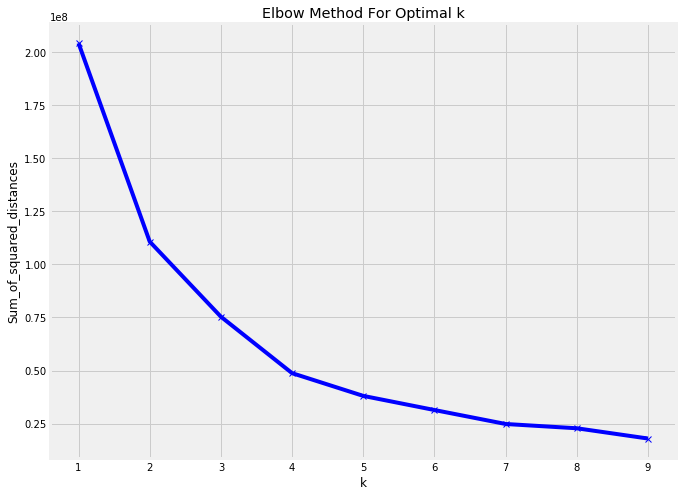

In [15]:
plt.figure(figsize=(10,8))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [16]:
kmeans_img = KMeans(n_clusters=2)
kmeans_img.fit(A)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Images below present the key difference that is hair-color. Eyeballing the dataset shows that it may be hair-color or inclusion of top-of-head hair in the image.

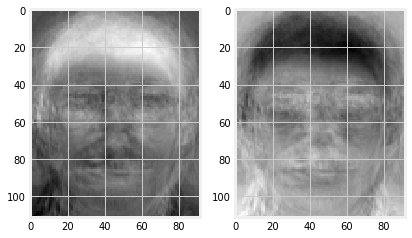

In [17]:
k1 = kmeans_img.cluster_centers_[0].reshape(112,92)
k2 = kmeans_img.cluster_centers_[1].reshape(112,92)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(k1, cmap='gray')
axarr[1].imshow(k2, cmap='gray')

### Validation

An analysis done using sklearns PCA library results in the same 2-PC projection, albeit with a different orientation of axes. Clustering this dataset will result in the same clusters as the original analysis.

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(A)
pdf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

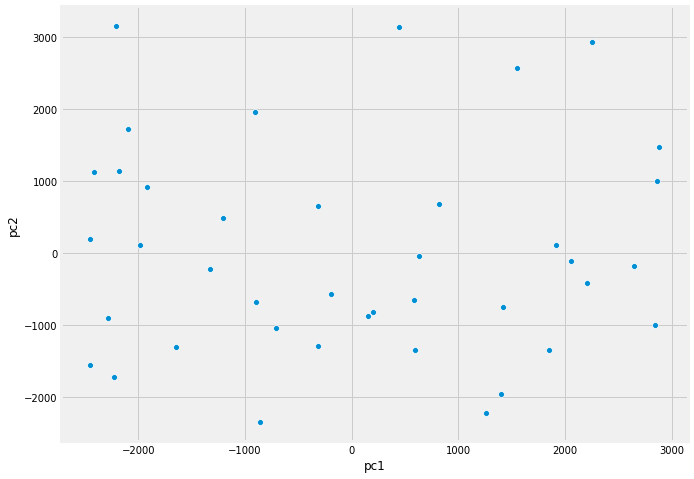

In [19]:
plt.figure(figsize=(10,8))
sns.scatterplot(pdf.pc1, pdf.pc2)

### Recommendations

More data and improved data sampling balance is recommended to better identify key features between genders and or facial features. In this dataset, only 10% of the data is tagged as female. This results in an unfavorable data skew in limiting identification or characterization of the female gender within the dataset.

A different approach to grouping the data is recommended. A spectral clustering algorithm can be explored in identifying groupings of the data that limits the prohibitive effects of purely euclidean based distance clustering methods. Following density-based approaches may result in a higher number of groupings within the data given that it might emphasize smaller facial features and is therefore also a recommended analysis.